<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) deep network,
(2) cost function, (3) method of calculating accuracy,
(4) an image that shows the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 40% Proper implementation of a loss function and train/test set accuracy measure
* 10% Tidy visualizations of loss and accuracy of your dense predictor during training
* 10% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

**DONE:**
* Watch tutorial

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

### Part 1a
Implement your network topology


Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Answer Question / Reflect on simplest network with the desired properties

**DONE:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose

___
The intention of this lab is to learn how to make deep neural nets and implement loss function.
Therefore we'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network implementation, losses and accuracies.

My answer to question above:

It is the simplest layer because it would produce the correct output dimensions but it wouldn't do much because it is linear. In order to get a good neural network we need to add some non-linearity into the mix.

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

___

### Part 1b
Implement a cost function

You should still use cross-entropy as your cost function, but you may need to think hard about how exactly to set this up – your network should output cancer/not-cancer probabilities for each pixel, which can be viewed as a two-class classification problem.

**TODO:**

**DONE:**

* Adapt CrossEntropyLoss for 2 class pixel classification



In [3]:
# Since you will be using the output of one network in two places(convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

class CancerDetectionNetwork(nn.Module):
  def __init__(self, in_channels, out_channels, filter_depth, u_depth):
    super(CancerDetectionNetwork, self).__init__()
    self.net_depth = u_depth
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.normalize_sub = 0
    self.normalize_div = 255

    self.down_convs = nn.ModuleList()
    self.down_samples = nn.ModuleList()
    self.up_samples = nn.ModuleList()
    self.up_convs = nn.ModuleList()
    
    activation_func = nn.ReLU

    # Variables to help keep track of the size of the tensor at each layer
    size = filter_depth
    previous_size = self.in_channels
    current_size = size

    # Create path down the U
    for i in range(self.net_depth) :
        self.down_convs.append(nn.Sequential(
            nn.Conv2d(previous_size, current_size, kernel_size=3, stride=1, padding=1),
            activation_func(),
            nn.Conv2d(current_size, current_size, kernel_size=3, stride=1, padding=1),
            activation_func(),
        ))

        self.down_samples.append(nn.MaxPool2d(kernel_size=2))
        previous_size = current_size
        current_size *= 2

    # Create bottom layer
    self.bottom = nn.Sequential(
        nn.Conv2d(previous_size, current_size, kernel_size=3, stride=1, padding=1),
        activation_func(),
        nn.Conv2d(current_size, current_size, kernel_size=3, stride=1, padding=1),
        activation_func()
    )

    # Create path up the U
    for i in range(self.net_depth) :

        next_size = current_size//2
        self.up_samples.append(nn.Sequential(
            nn.ConvTranspose2d(current_size, next_size, kernel_size=2, stride=2, padding=0),
            activation_func(),
        ))

        self.up_convs.append(nn.Sequential(
            nn.Conv2d(next_size, next_size, kernel_size=3, stride=1, padding=1),
            activation_func(),
            nn.Conv2d(next_size, next_size, kernel_size=3, stride=1, padding=1),
            activation_func(),
        ))
        current_size = next_size
    
    self.final = nn.Conv2d(current_size, self.out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    x = self.normalize_input_(x)

    # Go down through the u
    activations = [] # Keep track of outputs for going up
    for i in range(self.net_depth) :
        x = self.down_convs[i](x)
        activations.append(x)
        x = self.down_samples[i](x)

    x = self.bottom(x)

    # Come back up
    for i in range(self.net_depth) :
        x = self.up_samples[i](x)
        x = x + activations[-(i+1)]
        x = self.up_convs[i](x)

    return self.final(x)

  def normalize_input_(self, x):
      x -= self.normalize_sub
      x /= self.normalize_div
      return x


In [4]:
# Trainer class
class CancerSegmentationTrainer():
    def __init__(self):
        self.model = None
        self.optimizer = None
        self.loss_func = None
        self.train_dataloader = None 
        self.val_dataloader = None

        self.device = 'cuda'
        self.epoch_count = 0
        self.loop = None

    def increment_epoch_count(self):
        self.epoch_count += 1

    def train(self, num_epochs):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for i in range(1, num_epochs+1):
            self.loop = tqdm(total=len(self.train_dataloader), position=0, leave=False)
            # Train
            print(f'\nTraining for epoch {i} of {num_epochs}')
            train_loss, train_acc = self.train_epoch_(self.train_dataloader, training=True)
            self.loop.close()

            self.loop = tqdm(total=len(self.val_dataloader), position=0, leave=False)
            # Validate
            print(f"\nValidation for epoch {i} of {num_epochs}")
            val_loss, val_acc = self.train_epoch_(self.val_dataloader, training=False)
            self.loop.close()
            

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

        return  train_losses, val_losses, train_accuracies, val_accuracies

    def train_epoch_(self, data_loader, training=True):
        if training:
            self.model.train() 
            torch.set_grad_enabled(True)
        else:
            self.model.eval()
            torch.set_grad_enabled(False)

        loss_sum = 0
        acc_sum = 0
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device,non_blocking=True) # non_blocking is a speed up (async)
            
            if training:
                self.optimizer.zero_grad() # Set gradient to zero

            y_hat = self.model(imgs)
            loss = self.loss_func(y_hat, labels.long())
            loss_sum += loss.detach().sum().item()

            # Figure out a way to do accuracy
            probs = y_hat.argmax(1)
            accuracy = (probs == labels).float().mean()
            acc_sum += accuracy.detach().item()

            mem_allocated = torch.cuda.memory_allocated(0) / 1e9

            self.loop.set_description('loss: {:.4f}, accuracy: {:.4f}, mem: {:.2f}'.format(loss.detach().sum().item(), accuracy, mem_allocated))
            self.loop.update(1)

            if training:
                loss.backward() # Compute gradient, for weight with respect to loss
                self.optimizer.step() # Take step in the direction of the negative gradient

        return loss_sum / len(data_loader.dataset), acc_sum / len(data_loader.dataset)


In [5]:
# Visualization tools
def tensor_as_np_img(tensor):
    #tensor = tensor / 2 + 0.5
    return tensor.numpy()

def show_tensor_img(tensor):
    img = tensor_as_np_img(tensor)
    plt_img = np.transpose(img, (1, 2, 0))
    if (plt_img.shape[2] < 2):
        plt.imshow(plt_img.squeeze() * 255, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(plt_img)
    plt.show()

def show_loss_graph(title, train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(title)
    plt.ylabel("Avg. Loss per epoch")
    plt.xlabel("Epochs")
    plt.ylim([0, max(max(train_losses), max(val_losses))])
    plt.xlim([0, len(train_losses)])
    plt.legend()
    plt.show()

def show_accuracy_graph(title, train_acc, val_acc):
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(title)
    plt.ylabel("Avg. Accuracy per epoch (%)")
    plt.xlabel("Epochs")
    plt.ylim([0, max(max(train_acc), max(val_acc))])
    plt.xlim([0, len(train_acc)])
    plt.legend()
    plt.show()

In [11]:
# Instantiate data sets
train_dataset = CancerDataset('/tmp', train=True)
val_dataset = CancerDataset('/tmp', train=False)

# Instantiate your data loaders
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          batch_size=4,
                          num_workers=4,
                          pin_memory=True,)

val_loader = DataLoader(val_dataset,
                        shuffle=True,
                        batch_size=4,
                        num_workers=4,
                        pin_memory=True)


In [16]:
# Instantiate the model
device = "cuda"

model = CancerDetectionNetwork(
    in_channels=3,
    out_channels=2,
    filter_depth=64,
    u_depth=4
).to(device)

In [17]:
# Instantiate loss function and optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate
)
loss_func = nn.CrossEntropyLoss().to(device)

# Instantiate trainer
trainer = CancerSegmentationTrainer()
trainer.model = model
trainer.optimizer = optimizer
trainer.loss_func = loss_func
trainer.train_dataloader = train_loader
trainer.val_dataloader = val_loader

In [ ]:
train_losses = [] 
val_losses = [] 
train_acc = [] 
val_acc = []

def scope():
  try:
    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)

    # Train
    num_epochs = 20
    train_losses, val_losses, train_acc, val_acc = trainer.train(num_epochs)
    
  except:
    __ITB__()
    
scope()


In [20]:
num_epochs = 20
train_losses, val_losses, train_acc, val_acc = trainer.train(num_epochs)

  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 1 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 1 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 2 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 2 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 3 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 3 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 4 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 4 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 5 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 5 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 6 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 6 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 7 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 7 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 8 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 8 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 9 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 9 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 10 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 10 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 11 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 11 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 12 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 12 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 13 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 13 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 14 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 14 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 15 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 15 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 16 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 16 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 17 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 17 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 18 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 18 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 19 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 19 of 20


  0%|          | 0/336 [00:00<?, ?it/s]


Training for epoch 20 of 20


  0%|          | 0/44 [00:00<?, ?it/s]


Validation for epoch 20 of 20



___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)

**DONE:**


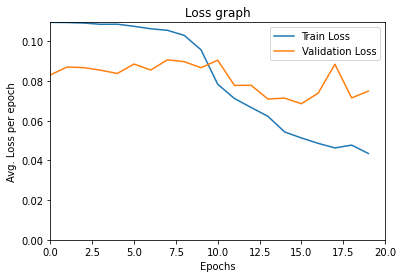

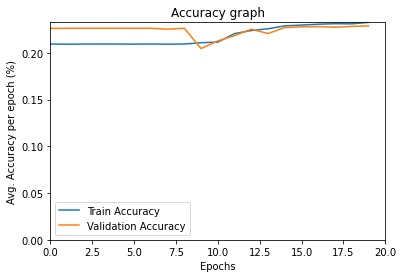

In [21]:
show_loss_graph("Loss graph", train_losses, val_losses)

show_accuracy_graph("Accuracy graph", train_acc, val_acc)


___

### Part 3

Generate a prediction on the pos_test_000072.png image

Calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

**TODO:**

**DONE:**

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

Base Image


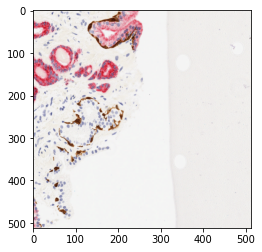

Diagnosis - Truth


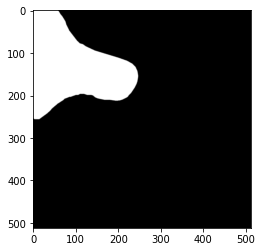

Diagnosis - Prediction


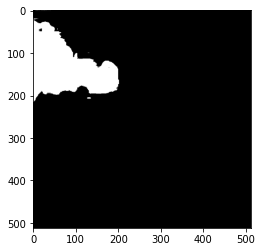

In [29]:
# Code for testing prediction on an image
test_img, test_label = val_dataset[172]
print('Base Image')
show_tensor_img(test_img)

print('Diagnosis - Truth')
show_tensor_img(test_label.unsqueeze(0))

model.eval()

img_batch = torch.unsqueeze(test_img, 0)
img_batch = img_batch.to(device)
prediction = model(img_batch)
prediction = prediction.argmax(1).to('cpu')

print('Diagnosis - Prediction')
show_tensor_img(prediction)